In [1]:
# Use this notebook for feature selection.
# First, look at correlation with target variable.  Remove outliers.  Select 

In [463]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from ipywidgets import interact, interact_manual
%matplotlib inline
import matplotlib.pyplot as plt

In [470]:
# read in data
train = pd.read_csv('../data/clean_train.csv', index_col=0)
test = pd.read_csv('../data/clean_test.csv', index_col=0)


In [471]:
# initial modifications
# set target
target = train['SalePrice']

# change MSSubClass to string
train['MSSubClass'] = train['MSSubClass'].astype(str)




# remove 'SalePrice' as it is the target variable.
#train.drop('SalePrice', axis = 1, inplace = True)

In [522]:
train['GarageYrBlt'].dtype

dtype('int64')

In [474]:
# feature classification

# separate data frames with numerical and categorical features
numericals = train.select_dtypes(include=[np.number])
categoricals = train.select_dtypes(exclude=[np.number])

# lists of numerical and categorical features
num_list = numericals.columns.tolist()
cat_list = categoricals.columns.tolist()

### Categorical Variable Classification
nominals = []
ordinals = []


In [481]:
# numerical correlations with target variable

num_corr = numericals.corr()['SalePrice']


In [514]:
# positive correlation plots
s = 3
fs = 15

x_list = num_corr[num_corr > 0].sort_values(ascending = False).index.tolist()
del x_list[0]
@interact
def corr_vis(feature=x_list, outliers=True):
    mask = (np.abs(stats.zscore(train[feature])) > s)
    if outliers:
        y = target
        x = train[feature]
    else:
        y = target[~mask]
        x = train[feature][~mask]
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,7.5))
    plt.rc('xtick', labelsize=fs) 
    plt.rc('ytick', labelsize=fs) 
    
    ax1.scatter(x=x, y=y)
    ax1.set_title('SalePrice vs {}'.format(feature), fontsize = fs)
    ax1.set_xlabel(feature, fontsize = fs)
    ax1.set_ylabel('SalePrice', fontsize = fs)

    ax2.hist(x=x)
    ax2.set_title('Distribution of {}'.format(feature), fontsize = fs)
    ax2.set_xlabel(feature, fontsize = fs)
    ax2.set_ylabel('Count', fontsize = fs)

    
    

interactive(children=(Dropdown(description='feature', options=('GrLivArea', 'GarageCars', 'GarageArea', 'Total…

In [ ]:
# FullBath is strictly increasing, and can probably be treated as ordinal categorical
# X3SsnPorch's 0 values greatly span past the maximum SalePrice.  It makes me think this feature isn't necessary.
# MoSold: most sales happen in the summer, but there isn't much affect on the SalePrice
# GarageCars would be strictly increasing were it not for category 4 (4-car-garage)
# 

In [220]:
# negative correlations
quant_corr[quant_corr < 0].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
OverallCond     -0.077856
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

In [515]:
# negative correlation plots
# s = 3
# fs = 15

# x_list = quant_corr[quant_corr < 0].sort_values().index.tolist()
# del x_list[0]
# @interact
# def corr_vis(feature=x_list, outliers=True):
#     mask = (np.abs(stats.zscore(train[feature])) > s)
#     if outliers:
#         y = target
#         x = train[feature]
#     else:
#         y = target[~mask]
#         x = train[feature][~mask]
    
#     plt.scatter(x = x, y = y)
#     plt.title('SalePrice vs {}'.format(feature), fontsize = fs)
#     plt.xlabel(feature, fontsize = fs)
#     plt.ylabel('SalePrice', fontsize = fs)
#     plt.xticks(fontsize = fs)
#     plt.yticks(fontsize = fs)

In [ ]:
exclusion_list = ['BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'OverallCond', 'KitchenAbvGr']

In [528]:
# dummify all categorical variables then concat with SalePrice and look at linear relationship with target

cat_dum = pd.get_dummies(categoricals, drop_first=True)
cat_target = pd.concat([cat_dum,target], axis=1)

In [530]:
# all correlations with SalePrice
cat_target_corr = cat_target.corr()['SalePrice']


In [532]:
# positive categorical correlation plots
s = 3
fs = 15

x_list = cat_target_corr[cat_target_corr > 0].index.tolist()
del x_list[0]
@interact
def corr_vis(feature=x_list, outliers=True):
    mask = (np.abs(stats.zscore(train_dum[feature])) > s)
    if outliers:
        y = target
        x = train_dum[feature]
    else:
        y = target[~mask]
        x = train_dum[feature][~mask]
    
    plt.scatter(x = x, y = y)
    plt.title('SalePrice vs {}'.format(feature), fontsize = fs)
    plt.xlabel(feature, fontsize = fs)
    plt.ylabel('SalePrice', fontsize = fs)
    plt.xticks(fontsize = fs)
    plt.yticks(fontsize = fs)
    

interactive(children=(Dropdown(description='feature', options=('MSSubClass_20', 'MSSubClass_50', 'MSSubClass_6…

In [ ]:
# How important is GarageYrBlt?
train['GarageYrBlt']
x = sm.add_constant(train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(trainY, x)
results = model.fit()
print(results.summary())

In [252]:
idx_years = train.GarageYrBlt[train.GarageYrBlt != 'None'].index
X_garage_years = pd.DataFrame(train.loc[idx_years])
X_garage_years['GarageYrBlt'] = X_garage_years['GarageYrBlt'].astype(int)
Y = train.loc[idx_years]['SalePrice']


In [261]:

s = 3
fs = 15
target = X_garage_years['SalePrice']
x_list = ['GarageYrBlt']

@interact
def corr_vis(feature=x_list, outliers=True):
    mask = (np.abs(stats.zscore(X_garage_years[feature])) > s)
    if outliers:
        y = target
        x = X_garage_years[feature]
    else:
        y = target[~mask]
        x = X_garage_years[feature][~mask]
    
    plt.scatter(x = x, y = y)
    plt.title('SalePrice vs {}'.format(feature), fontsize = fs)
    plt.xlabel(feature, fontsize = fs)
    plt.ylabel('SalePrice', fontsize = fs)
    plt.xticks(fontsize = fs)
    plt.yticks(fontsize = fs)

interactive(children=(Dropdown(description='feature', options=('GarageYrBlt',), value='GarageYrBlt'), Checkbox…

In [393]:
# pivot table to decide what to do with heating values
# Further work: include frequency into visualization.  Color bars based on frequency.
cat_list = categoricals.columns.tolist()
@interact
def pivots(feature=cat_list):
    condition_pivot = train.pivot_table(index=feature, values='SalePrice', aggfunc=np.median)
    condition_pivot.plot(kind='bar', color='blue', figsize = (15,5))
    plt.xlabel(feature)
    plt.ylabel('Median Sale Price')
    plt.xticks(rotation=0)
    plt.show()

interactive(children=(Dropdown(description='feature', options=('MSSubClass', 'MSZoning', 'Street', 'Alley', 'L…

In [543]:
cat_list = categoricals.columns.tolist()
@interact
def pivots(feature=cat_list):
    color_map = mp.colors.LinearSegmentedColormap(
        "my_map",
        {
            "red": [(0, 0.0, 0),
                    (1.0, 0.0, 0)],
            "green": [(0, 0, 1.0),
                      (0.25,0,0.25),
                      (0.5,0,0.5),
                      (0.75,0,0.75),
                      (1.0, 0, 0)],
            "blue": [(0, 0.0, 0.0),
                     (1.0, 0, 0)]
        }
)
     
    
    data1 = train.groupby(feature)[feature].count()
    colors=color_map(data_normalizer((data1.values)))
    
    fs = 15
    m = 15
    n = 5
    plt.figure(figsize=(m,n))
    condition_pivot = train.pivot_table(index=feature, values='SalePrice', aggfunc=np.median).reset_index()
    g=sns.barplot(x=feature,y='SalePrice', palette = colors, data=condition_pivot)
    plt.xlabel(feature, fontsize = fs)
    plt.ylabel('Median Sale Price', fontsize = fs)
    plt.xticks(rotation=0)
    
    plt.show()

interactive(children=(Dropdown(description='feature', options=('MSSubClass', 'MSZoning', 'Street', 'Alley', 'L…

interactive(children=(Dropdown(description='feature', options=('MSSubClass', 'MSZoning', 'Street', 'Alley', 'L…

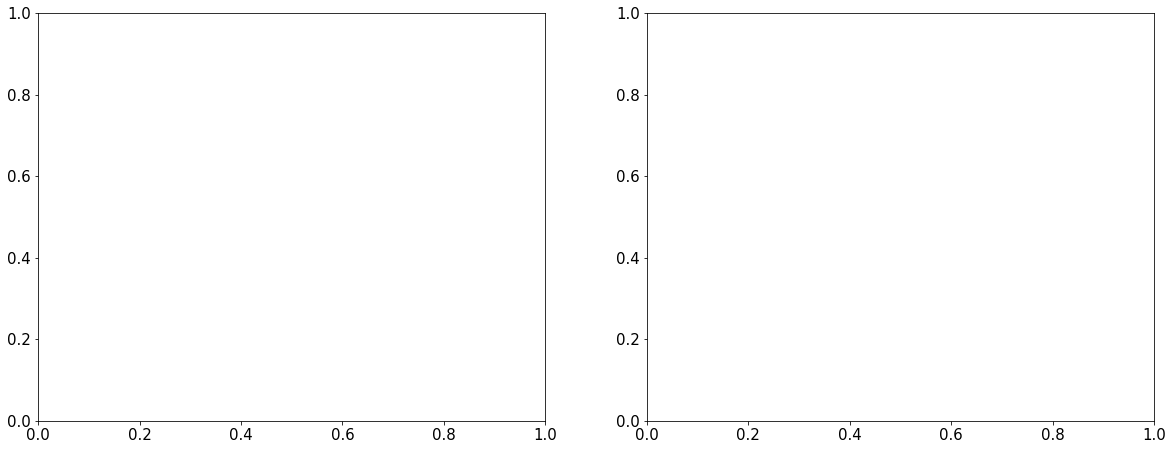

In [547]:

plt.rc('xtick', labelsize=fs) 
plt.rc('ytick', labelsize=fs) 
cat_list = categoricals.columns.tolist()
@interact
def pivots(feature=cat_list):
    color_map = mp.colors.LinearSegmentedColormap(
        "my_map",
        {
            "red": [(0, 0.0, 0),
                    (1.0, 0.0, 0)],
            "green": [(0, 0, 1.0),
                      (0.25,0,0.25),
                      (0.5,0,0.5),
                      (0.75,0,0.75),
                      (1.0, 0, 0)],
            "blue": [(0, 0.0, 0.0),
                     (1.0, 0, 0)]
        }
)
     
#     fs = 15
#     m = 15
#     n = 5
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,7.5))
    
    plt.rc('xtick', labelsize=fs) 
    plt.rc('ytick', labelsize=fs) 
    
    sns.barplot(x=feature,y='SalePrice', palette = colors, data=condition_pivot, ax=ax1)
    ax1.set_title('SalePrice vs {}'.format(feature), fontsize = fs)
    ax1.set_xlabel(feature, fontsize = fs)
    ax1.set_ylabel('SalePrice', fontsize = fs)

    ax2.hist(x=x)
    ax2.set_title('Distribution of {}'.format(feature), fontsize = fs)
    ax2.set_xlabel(feature, fontsize = fs)
    ax2.set_ylabel('Count', fontsize = fs)
    data1 = train.groupby(feature)[feature].count()
    colors=color_map(data_normalizer((data1.values)))

    
    
    
#     plt.figure(figsize=(m,n))
#     condition_pivot = train.pivot_table(index=feature, values='SalePrice', aggfunc=np.median).reset_index()
#     g=
#     plt.xlabel(feature, fontsize = fs)
#     plt.ylabel('Median Sale Price', fontsize = fs)
#     plt.xticks(rotation=0)
    
    plt.show()